In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [21]:
test_set = pd.read_csv("data/test_set.csv")
train_set = pd.read_csv("data/train_set.csv")

In [22]:
train_set

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,25,0,0,0,1,1,...,1,0,2,1,1,0,0,11,6,8
1,0,0,0,0,33,0,0,0,1,1,...,1,0,3,3,1,0,1,7,4,8
2,0,1,0,1,33,1,0,0,1,1,...,1,0,4,1,1,0,0,8,4,3
3,2,1,1,1,26,1,1,1,1,1,...,1,0,3,1,1,1,1,12,6,3
4,0,1,1,1,35,1,0,0,0,1,...,1,0,4,3,2,1,0,11,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174329,0,0,0,1,27,1,0,0,1,0,...,1,0,2,1,1,0,1,11,4,7
174330,2,1,1,1,36,0,0,1,0,1,...,1,0,5,1,6,1,0,10,4,3
174331,0,1,1,1,31,0,0,0,1,1,...,1,0,2,1,1,0,0,10,6,8
174332,0,1,0,1,38,0,0,0,1,1,...,1,0,3,1,3,0,0,1,4,5


In [23]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

train_binary_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_set.values), columns=train_set.columns, index=train_set.index)
test_binary_scaled = pd.DataFrame(min_max_scaler.transform(test_set.values), columns=test_set.columns, index=test_set.index)

X_train = train_binary_scaled.drop("Diabetes_012", axis = 1)
y_train = train_binary_scaled["Diabetes_012"]

X_test = test_binary_scaled.drop("Diabetes_012", axis = 1)
y_test = test_binary_scaled["Diabetes_012"]

### Evaluate a few models based on roc_auc, without hyperparameter tuning

In [24]:
models = {"Logistic Regression": LogisticRegression(random_state = 42, n_jobs = -1), 
          "KNN": KNeighborsClassifier(), 
          "Decision Tree Classifier": DecisionTreeClassifier(random_state = 42),
          #"Random Forest Classifier": RandomForestClassifier(random_state = 42),
          #'gboost': GradientBoostingClassifier(random_state=42),
          #'xgb': XGBClassifier(random_state=42),
          #'svm': SVC(),
          #'bayes': GaussianNB()
         }
results = []

Roc_auc scores for  Logistic Regression :  [0.82272995 0.82381988]
Mean roc_auc_score for  Logistic Regression :  0.8232749128790444
Median roc_auc_score for  Logistic Regression :  0.8232749128790444 

Roc_auc scores for  KNN :  [0.72155437 0.71950261]
Mean roc_auc_score for  KNN :  0.7205284897762897
Median roc_auc_score for  KNN :  0.7205284897762897 

Roc_auc scores for  Decision Tree Classifier :  [0.60048084 0.60000667]
Mean roc_auc_score for  Decision Tree Classifier :  0.6002437535864172
Median roc_auc_score for  Decision Tree Classifier :  0.6002437535864172 



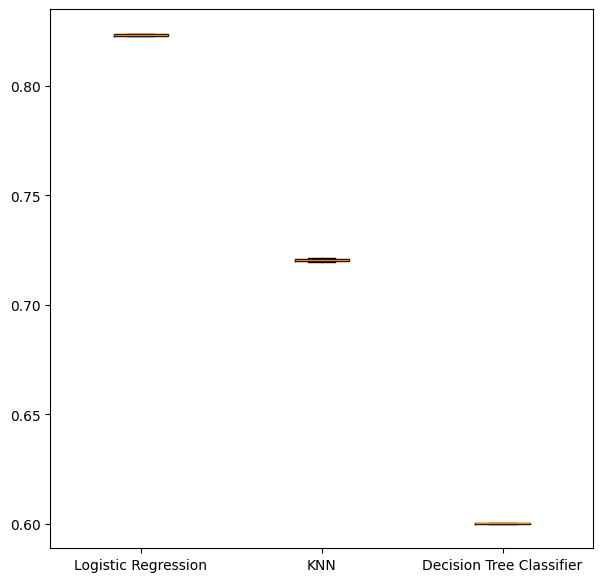

In [25]:
for model in models.values():
    kf = KFold(n_splits = 2, random_state = 42, shuffle = True)
    res_for_model = cross_val_score(model, X_train, y_train, cv = kf, scoring = "roc_auc", n_jobs = -1)
    results.append(res_for_model)

i = 0
for name in models.keys():
    print("Roc_auc scores for ", name, ": ", results[i])
    print("Mean roc_auc_score for ", name, ": ", np.mean(results[i]))
    print("Median roc_auc_score for ", name, ": ", np.median(results[i]), "\n")
    i = i+1

plt.figure(figsize = (7,7))
plt.boxplot(results, labels = models.keys())
plt.show()

### Estimated roc_auc scores for models on training set:
Median roc_auc_score for  Logistic Regression :  0.8235191188536042 

Median roc_auc_score for  KNN :  0.7186383191172674 

Median roc_auc_score for  Decision Tree Classifier :  0.6025431389404231 

Median roc_auc_score for  Random Forest Classifier :  0.7966651322736205 


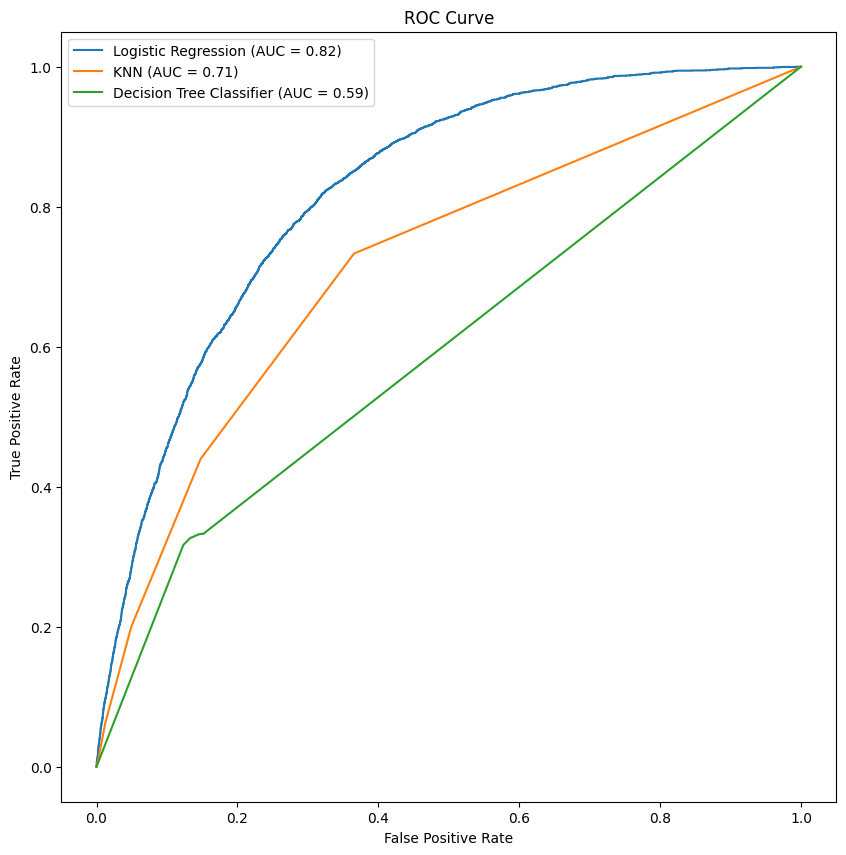

In [26]:
# Lista na wyniki AUC dla każdego modelu
auc_scores = []
conf_matrices = []
classification_reports = []
plt.figure(figsize = (10,10))

# Wytrenowanie modeli i ocena na zbiorze testowym
for name, model in models.items():
    # Trenowanie modelu na zbiorze treningowym
    model.fit(X_train, y_train)
    
    # Predykcja na zbiorze testowym
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    
    # Obliczenie AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)
    
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred))
    
    # Rysowanie krzywej ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Dodanie informacji na wykresie
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [27]:
# Porównanie wyników dla ROC AUC SCORE
auc_scores_train = []
for i in range(len(results)):
    auc_scores_train.append(np.mean(results[i]))
    
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree Classifier'], #, 'Random Forest Classifier', 'Gradient Boosting Classifier', 'XgBoost', "SVM", "Bayes"],
    'Roc_auc Train': auc_scores_train,
    'Roc_auc Test': auc_scores
})
models.sort_values(by = 'Roc_auc Test', ascending = False)

,Model,Roc_auc Train,Roc_auc Test
0,Logistic Regression,0.823275,0.821773
1,KNN,0.720528,0.714200
2,Decision Tree Classifier,0.600244,0.594146


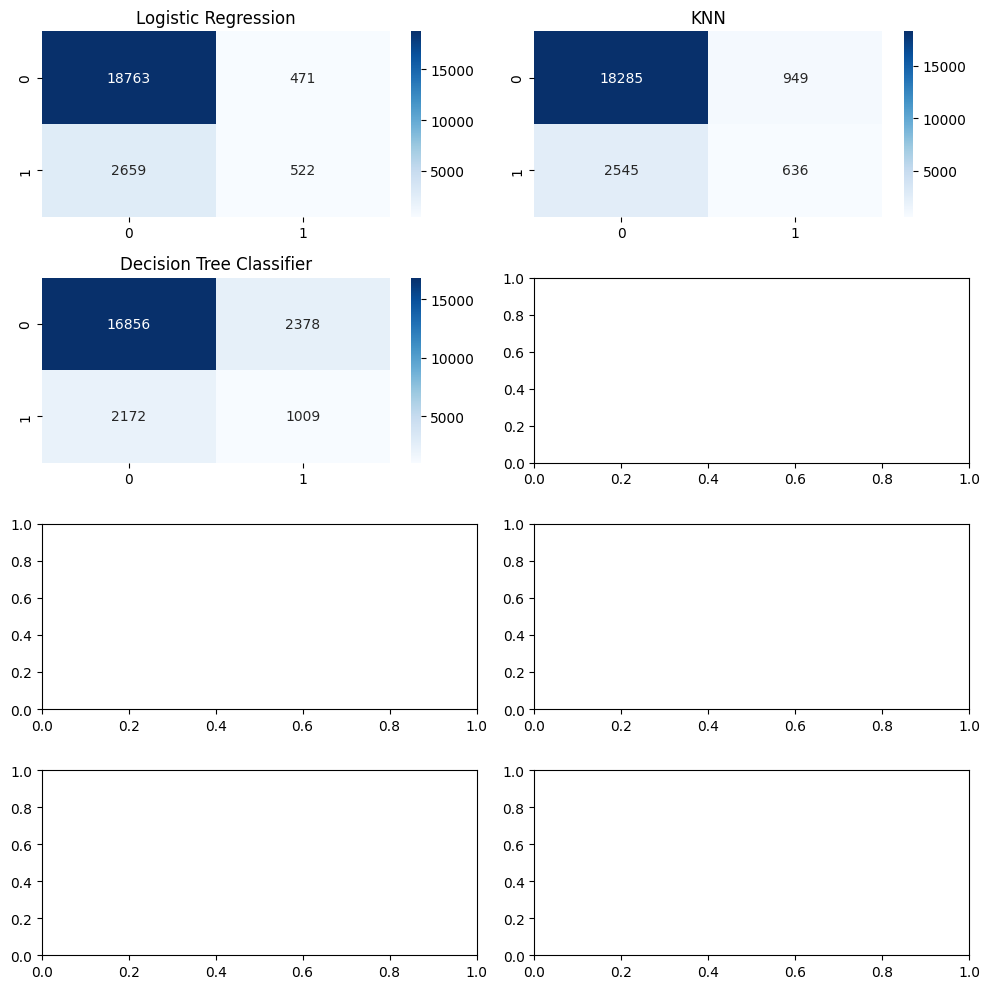

In [28]:
import seaborn as sns
# Porównanie macierzy
model_names = ['Logistic Regression', 'KNN', 'Decision Tree Classifier']  #, 'Random Forest Classifier', 'Gradient Boosting Classifier', 'XgBoost', "SVM", "Bayes"]
fig, ax = plt.subplots(4, 2, figsize = (10,10))

# Plotting confusion matrices
for i, (model_name, conf_matrix) in enumerate(zip(model_names, conf_matrices)):
    # Calculate row and column indices for subplot
    row = i // 2
    col = i % 2
    
    # Plot confusion matrix on the corresponding subplot
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", ax=ax[row, col])
    
    # Set title for the subplot
    ax[row, col].set_title(model_name)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# Jeśli chcemy to są też raporty z metrykami np accuracy itp...

## Ensemble models

In [30]:
from sklearn.ensemble import VotingClassifier

In [31]:
# Wybieramy 3 najlepsze modele i dla nich robimy ensemble

# UWAGA: TU ZMIENIĆ NA FAKTYCZNIE 3 NAJLEPSZE
model1 = GradientBoostingClassifier()
model2 = KNeighborsClassifier()
model3 = LogisticRegression(random_state=42)
estimators=[('GradientBoosting', model1), ('KNN', model2), ('LR', model3)]

In [32]:
model_soft = VotingClassifier(estimators=estimators, voting='soft')
model_soft.fit(X_train, y_train)

y_pred_proba = model_soft.predict_proba(X_test)[:,1]
auc_ensemble_soft = roc_auc_score(y_test, y_pred_proba)
print("Ensemble model with soft voting roc_auc_score: ", auc_ensemble_soft)

Ensemble model with soft voting roc_auc_score:  0.8153272702245123


### Stacking

In [33]:
from sklearn.ensemble import StackingClassifier

In [34]:
# UWAGA: TU DAĆ NAPRAWDĘ 3 NAJLEPSZE MODELE
level0 = list()
level0.append(('LogReg', LogisticRegression()))
level0.append(('RandomForest', RandomForestClassifier(
                                      max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                      max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                      random_state=42,
                                      n_jobs = -1)))
level0.append(('GBoost', GradientBoostingClassifier(random_state=42,
                                      learning_rate=0.01)))

level1 = LogisticRegression()
    
model_stack = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)

model_stack.fit(X_train, y_train)

y_pred_proba = model_stack.predict_proba(X_test)[:,1]
auc_stack = roc_auc_score(y_test, y_pred_proba)
print("Stacking model roc_auc_score: ", auc_stack)

Stacking model roc_auc_score:  0.8164025136640924


In [35]:
y_pred_proba = model_stack.predict_proba(X_test)[:,1]
auc_stack = roc_auc_score(y_test, y_pred_proba)
print("Stacking model roc_auc_score: ", auc_stack)

Stacking model roc_auc_score:  0.8164025136640924


### Wnioski:
- modele ensemble takie jak soft i stacking charakteryzują się wysokim wskaźnikiem roc_auc

- wskaźnik ten jest jednak niższy niż w przypadku prostego modelu regresji logistycznej

- w dalszej części projektu zdecydowano się na wybranie modelu regresji logistycznej do przewidywania prawdopodobieństwa zachorowania na cukrzycę

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score,roc_auc_score
import numpy as np

# Define the parameter grid with lof ot parameters
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'max_iter': [100, 1000, 10000, 100000],
    'fit_intercept': [True, False],
    'class_weight': ['balanced'],
    'l1_ratio': np.linspace(0, 1, 5)
}


# Define the model
log_reg = LogisticRegression()

# Define the scorer
# scorer = make_scorer(recall_score)
scorer = make_scorer(roc_auc_score,needs_threshold=True)

# Define the grid search
grid_search = RandomizedSearchCV(log_reg, param_grid, scoring=scorer, cv=3, n_iter=100, random_state=0,verbose=1)

# Fit the grid search, i want to prints
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warni

KeyboardInterrupt: 

In [38]:
#run me logistic regression on test data and {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.2222222222222222, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.01}
log_reg = LogisticRegression(solver='lbfgs', penalty='l2', l1_ratio=0.2222222222222222, fit_intercept=True, class_weight='balanced', C=0.01)
log_reg.fit(X_train, y_train)

y_pred_proba = log_reg.predict_proba(X_test)[:,1]
auc_log_reg = roc_auc_score(y_test, y_pred_proba)
print("Logistic Regression model roc_auc_score: ", auc_log_reg)


/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Logistic Regression model roc_auc_score:  0.8221765351405875


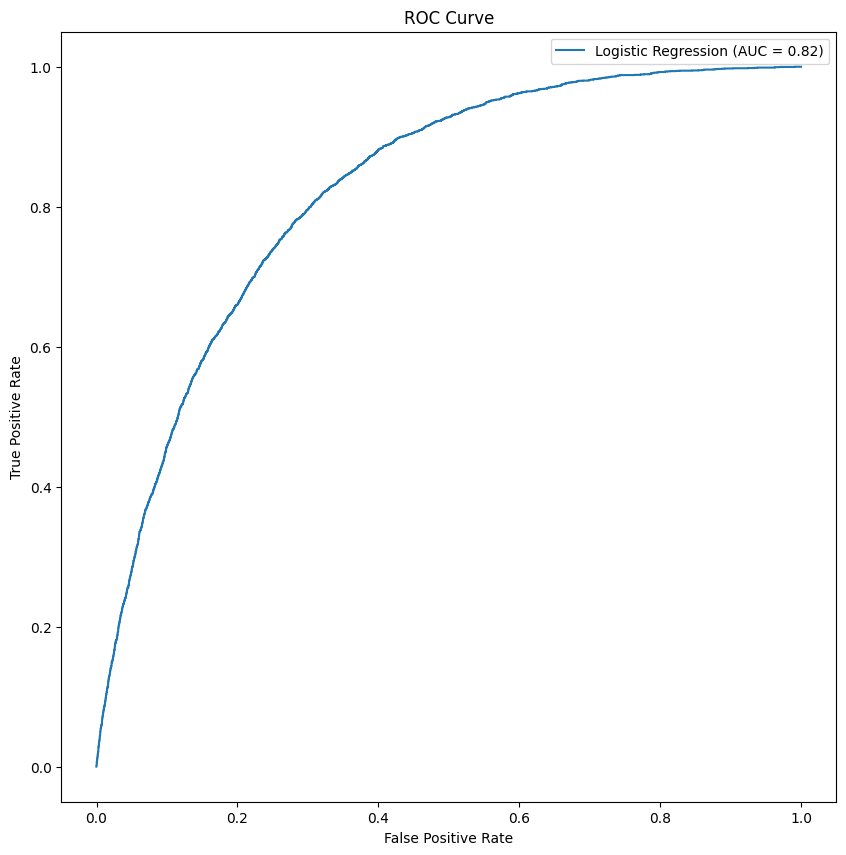

In [39]:
#visualise roc auc score
plt.figure(figsize=(10, 10))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_log_reg:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Saving log regression

In [ ]:
#save model into file
import joblib
joblib.dump(log_reg, 'log_reg.pkl')
